<a href="https://colab.research.google.com/github/raphaelp-silva/GNN_Predictive_Model_Obesity/blob/main/Model_GNN_SAGECONV_TESTING_Obesity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [173]:
!pip install faiss-cpu
!pip install torch_geometric
!pip install --upgrade skorch
!pip install optuna

In [174]:
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from google.colab import files
from torch_geometric.utils import to_networkx, subgraph
from scipy.stats import ks_2samp, ttest_ind
from torch_geometric.nn import SAGEConv, BatchNorm
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from torch_geometric.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import torch.nn.functional as F
import community.community_louvain as community_louvain
import optuna.visualization as vis

import os
import torch
import faiss
import torch_geometric
import kagglehub
import optuna
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# desabilita algoritmos não‐determinísticos no cudnn
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# (PyTorch ≥1.8)
torch.use_deterministic_algorithms(True)

In [175]:
# Fazendo o download da ultima versão via api
path = kagglehub.dataset_download("adeniranstephen/obesity-prediction-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/obesity-prediction-dataset


In [176]:
os.listdir(path) #listando os arquivos do diretorio

db = pd.read_csv(os.path.join(path, "ObesityDataSet_raw_and_data_sinthetic.csv"))

In [177]:
db.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [178]:
# Criando função para unificar os individuos de acordo com a label:
def unificar_categorias(df: pd.DataFrame) -> pd.DataFrame:
    """
    Recebe um DataFrame com a coluna 'NObeyesdad' e cria
    uma nova coluna 'obeso' com três categorias:
      - 'obeso'      para Obesity_Type_I, II, III
      - 'sobrepeso'  para Overweight_Level_I, II
      - 'normal'     para Normal_Weight e Insufficient_Weight
    """
    mapeamento = {
        'Obesity_Type_I':   'obeso',
        'Obesity_Type_II':  'obeso',
        'Obesity_Type_III': 'obeso',
        'Overweight_Level_I':  'sobrepeso',
        'Overweight_Level_II': 'sobrepeso',
        'Normal_Weight':       'peso adequado',
        'Insufficient_Weight':'peso adequado'
    }
    # Aplica o mapeamento e, caso apareça algo fora do esperado,
    # atribui 'outro' (opcional)
    df['Status'] = df['NObeyesdad'].map(mapeamento).fillna('outro')
    return df


In [179]:
# Chamando e aplicando a função no dataframe:
db = unificar_categorias(db)

In [180]:
# Filtrando os indivíduos, retirando os pacientes com status 'sobrepeso':
db = db[db['Status'] != 'sobrepeso'].reset_index(drop=True)

In [181]:
# Agrupando por Status e verificando o filtro aplicado acima:
db.groupby('Status').count()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
Status,,,,,,,,,,,,,,,,,
obeso,972,972,972,972,972,972,972,972,972,972,972,972,972,972,972,972,972
peso adequado,559,559,559,559,559,559,559,559,559,559,559,559,559,559,559,559,559


In [182]:
# Retirando as colunas 'NObeyesdad', 'Height', 'Weight':
db.drop(columns=['NObeyesdad', 'Height', 'Weight'], inplace=True)

In [183]:
# Exibindo as primeiras linhas do dataframe:
db.head()

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Status
0,Female,21,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,peso adequado
1,Female,21,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,peso adequado
2,Male,23,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,peso adequado
3,Male,29,no,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Automobile,peso adequado
4,Female,23,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,0.0,Sometimes,Motorbike,peso adequado


In [184]:
# Verificando o tamanho do dataframe:
db.shape

(1531, 15)

In [185]:
# Convertendo colunas (yes/no) para valores binários:

colunas_binarias = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']

db.loc[:, colunas_binarias] = db[colunas_binarias].apply(lambda x: x.map({'yes': 1, 'no': 0})).astype(int)

# Convertendo coluna 'Gender' para valores binários:

db.loc[:, 'Gender'] = db['Gender'].map({'Female': 0, 'Male': 1})

In [186]:
# Convertendo valores das colunas de caracteres para valores numéricos:

# Lista das colunas categóricas que vamos transformar:
categorical_columns = ['CAEC', 'CALC', 'MTRANS', 'Status']

# Criando o OneHotEncoder e aplicando em todas as colunas de uma vez:
onehotencoder = ColumnTransformer(transformers=[("OneHot", OneHotEncoder(), categorical_columns)], remainder='passthrough')

# Transformando os valores:
encoded_data = onehotencoder.fit_transform(db)

# retornando os nomes das colunas geradas com o onehotencoder:
transformed_feature_names = onehotencoder.get_feature_names_out()

# criando um novo DataFrame com os valores:
encoded_df = pd.DataFrame(encoded_data, columns=transformed_feature_names).astype('int')
encoded_df.index = db.index

db_encoded = pd.concat([db.drop(columns=categorical_columns), encoded_df], axis=1)

print(db_encoded.shape)

(1531, 37)


In [187]:
# Dropando as colunas 'remainder__' que estão duplicadas no db_encoded:
db_encoded = db_encoded.drop(columns=[col for col in db_encoded.columns if 'remainder__' in col])

In [188]:
# Normalizando os dados:
lista_colunas_a_normalizar = ['Age','CH2O', 'FAF', 'TUE']

# Normalizando os dados:
scaler = StandardScaler()
db_encoded[lista_colunas_a_normalizar] = scaler.fit_transform(db_encoded[lista_colunas_a_normalizar])

In [189]:
# Exibindo as primeiras linhas do dataframe encoded:
db_encoded.head()

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,SCC,FAF,...,OneHot__CALC_Frequently,OneHot__CALC_Sometimes,OneHot__CALC_no,OneHot__MTRANS_Automobile,OneHot__MTRANS_Bike,OneHot__MTRANS_Motorbike,OneHot__MTRANS_Public_Transportation,OneHot__MTRANS_Walking,OneHot__Status_obeso,OneHot__Status_peso adequado
0,0,-0.505300,1,0,2.0,3.0,0,0.007700,0,-1.182977,...,0,0,1,0,0,0,1,0,0,1
1,0,-0.505300,1,0,3.0,3.0,1,1.613709,1,2.325982,...,0,1,0,0,0,0,1,0,0,1
2,1,-0.166293,1,0,2.0,3.0,0,0.007700,0,1.156329,...,1,0,0,0,0,0,1,0,0,1
3,1,0.850729,0,1,2.0,3.0,0,0.007700,0,-1.182977,...,0,1,0,1,0,0,0,0,0,1
4,0,-0.166293,1,1,3.0,3.0,0,0.007700,0,-0.013324,...,0,1,0,0,0,1,0,0,0,1


In [190]:
# Exibindo as colunas do dataframe:
db_encoded.columns

Index(['Gender', 'Age', 'family_history_with_overweight', 'FAVC', 'FCVC',
       'NCP', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'OneHot__CAEC_Always',
       'OneHot__CAEC_Frequently', 'OneHot__CAEC_Sometimes', 'OneHot__CAEC_no',
       'OneHot__CALC_Always', 'OneHot__CALC_Frequently',
       'OneHot__CALC_Sometimes', 'OneHot__CALC_no',
       'OneHot__MTRANS_Automobile', 'OneHot__MTRANS_Bike',
       'OneHot__MTRANS_Motorbike', 'OneHot__MTRANS_Public_Transportation',
       'OneHot__MTRANS_Walking', 'OneHot__Status_obeso',
       'OneHot__Status_peso adequado'],
      dtype='object')

In [191]:
# Verificando o tamanho do dataframe db_encoded:
db_encoded.shape

(1531, 26)

In [192]:
# Definindo as colunas-alvo (target) do nosso modelo:
target_columns = ['OneHot__Status_peso adequado',
                 'OneHot__Status_obeso']

In [193]:
# Separando X (features) e y (colunas-alvo):
X = db_encoded.drop(columns=target_columns)
y = db_encoded[target_columns]

In [194]:
# Convertendo labels one-hot (colunas) em um vetor 1-D de inteiros (0, 1, …):
y_labels = np.argmax(y.values, axis=1)

# Garantindo que não haja valores ausentes nos rótulos:
assert not np.isnan(y_labels).any(), "Há NaNs em y_labels!"

# Dividindo em treino (70%) + temporário (30%), com estratificação pelos rótulos:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_labels,
    test_size=0.3,
    random_state= SEED,
    stratify=y_labels
)
# Dividindo o conjunto temporário em validação (15%) e teste (15%), novamente estratificado:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state= SEED,
    stratify=y_temp
)
# Exibindo os tamanhos de cada partição:
print(f"Tamanho do treino:     {len(X_train)}")
print(f"Tamanho da validação: {len(X_val)}")
print(f"Tamanho do teste:      {len(X_test)}")

Tamanho do treino:     1071
Tamanho da validação: 230
Tamanho do teste:      230


In [195]:
# 1) Crie a coluna is_test com valor False em todas as linhas
db_encoded['is_test'] = False

# 2) Marque True nas linhas cujo índice está em X_test.index
db_encoded.loc[X_test.index, 'is_test'] = True

# Conferindo:
print(db_encoded['is_test'].sum())   # deve dar 230
print(db_encoded.loc[db_encoded['is_test'], :].shape)  # (230, …)

230
(230, 27)


In [196]:
# Contando quantas amostras de cada classe temos:
classe_counts = pd.Series(y_labels).value_counts().sort_index()

print("Distribuição por classe no y_train:")
print(classe_counts)

Distribuição por classe no y_train:
0    559
1    972
Name: count, dtype: int64


In [197]:
# convertendo as colunas para tipo float:
object_columns = db_encoded.select_dtypes(include=['object']).columns # selecionando as colunas do tipo objeto.

for col in object_columns:
    db_encoded[col] = pd.to_numeric(db_encoded[col], errors='coerce')

In [198]:
# Verificando os tipos de dados de cada coluna:
db_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1531 entries, 0 to 1530
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Gender                                1531 non-null   int64  
 1   Age                                   1531 non-null   float64
 2   family_history_with_overweight        1531 non-null   int64  
 3   FAVC                                  1531 non-null   int64  
 4   FCVC                                  1531 non-null   float64
 5   NCP                                   1531 non-null   float64
 6   SMOKE                                 1531 non-null   int64  
 7   CH2O                                  1531 non-null   float64
 8   SCC                                   1531 non-null   int64  
 9   FAF                                   1531 non-null   float64
 10  TUE                                   1531 non-null   float64
 11  OneHot__CAEC_Alwa

In [199]:
# Exibindo o tamanho do X_train:
print(X_train.shape)

(1071, 24)


In [200]:
# Tentando utilizar o FAISS para criação das conexões no grafo, caso contrário utiliza o sklearn:
try:
  import faiss
  use_faiss = True
except:
  from sklearn.neighbors import NearestNeighbors
  use_faiss = False

In [201]:
# Criando a função que processa os dados de entrada dos grafos.

def preprocess_features(X, y):
    """
    Preprocessa os dados de entrada:
    - Preenche valores ausentes com 0
    - Converte X para float32 e y para int

    Retorna:
        X (DataFrame), y (Series)
    """
    X = X.fillna(0).astype(np.float32)
    y = y.fillna(0).astype(int)
    return X, y

In [202]:
# Criando a função que cria o grafo baseado em distância Euclidiana.

def build_knn_graph(X_np, k):
    """
    Cria um grafo k-NN baseado em distância Euclidiana.

    Retorna:
        edge_index (torch.LongTensor): Formato [2, num_edges]
    """
    num_nodes = X_np.shape[0]

    if use_faiss:
        index = faiss.IndexFlatL2(X_np.shape[1])
        index.add(X_np)
        _, neighbors = index.search(X_np, k + 1)
    else:
        nn = NearestNeighbors(n_neighbors=k + 1).fit(X_np)
        neighbors = nn.kneighbors(X_np, return_distance=False)

    # Pré-alocação de arestas (bidirecional)
    edges = np.zeros((2, num_nodes * k * 2), dtype=np.int64)
    idx = 0
    for i in range(num_nodes):
        for j in range(1, k + 1):  # Ignora o próprio nó
            neighbor = neighbors[i, j]
            edges[0, idx] = i
            edges[1, idx] = neighbor
            idx += 1
            edges[0, idx] = neighbor
            edges[1, idx] = i
            idx += 1

    return torch.from_numpy(edges)

In [203]:
# Criando a função de coversão de dataframe para PyG.

def df_to_pyg_with_edges(X, y_labels, k=5):
    """
    Converte:
      - X: pd.DataFrame de features (pode ter NaNs)
      - y_labels: vetor 1-D de labels inteiros (np.ndarray ou list)
    em um objeto torch_geometric.data.Data, criando arestas de k-NN.

    Parâmetros:
        X (pd.DataFrame): Features dos nós.
        y_labels (array-like): Labels 0,1,2… para cada linha de X.
        k (int): Número de vizinhos para conectar cada nó.

    Retorna:
        Data: x=[num_nodes, num_features], edge_index=[2, num_edges], y=[num_nodes]
    """
    # 1) Preprocessando só o X
    X_proc = X.fillna(0).astype(np.float32)
    X_np   = X_proc.values  # array float32

    # 2) Construindo as arestas (sua função build_knn_graph)
    edge_index = build_knn_graph(X_np, k)  # deve devolver tensor [2, E]

    # 3) Tensor de features
    x_tensor = torch.tensor(X_np, dtype=torch.float)

    # 4) Tensor de labels — já é 1-D
    y_arr    = np.asarray(y_labels, dtype=np.int64)
    y_tensor = torch.tensor(y_arr, dtype=torch.long)

    return Data(x=x_tensor, edge_index=edge_index, y=y_tensor)

In [204]:
# Criando os grafos com conexões baseadas em similaridade

graph_train = df_to_pyg_with_edges(X_train, y_train, k=10)
graph_val   = df_to_pyg_with_edges(X_val,   y_val,   k=10)
graph_test  = df_to_pyg_with_edges(X_test,  y_test,  k=10)

# Exibindo informações sobre os grafos

print(graph_train) #1071 individuos
print(graph_val) #230 individuos
print(graph_test) #230 individuos

Data(x=[1071, 24], edge_index=[2, 21420], y=[1071])
Data(x=[230, 24], edge_index=[2, 4600], y=[230])
Data(x=[230, 24], edge_index=[2, 4600], y=[230])


<ipython-input-203-b576d6a0e059>:19: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-203-b576d6a0e059>:19: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-203-b576d6a0e059>:19: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [205]:
# Criando a função para plotar o grafo:

def plot_graph(graph, df):
    """Plota o grafo usando NetworkX e Matplotlib."""

    # Criando o grafo no NetworkX
    G = nx.Graph()
    edge_list = graph.edge_index.numpy().T  # Convertendo as arestas para NumPy
    G.add_edges_from(edge_list)  # Adicionando arestas ao NetworkX

    # Garantindo que os índices do DataFrame estejam alinhados corretamente com os nós
    df = df.reset_index(drop=True)  # Resetando os índices para garantir alinhamento correto

    # Definindo cores dos nós com base na obesidade (ou outro critério)
    color_map = [
        "blue" if df.loc[node, "OneHot__Status_peso adequado"] == 1 else "red"
        for node in G.nodes()
    ]

    # Plotando o grafo
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, k=0.3, iterations = 50, seed=42)  # Definindo um layout para visualização
    nx.draw(G, node_color=color_map, node_size=50, edge_color="gray", alpha=0.7, width=0.2)
    plt.title("Grafo de Indivíduos Conectados por Similaridade")
    plt.show()


In [206]:
# Exibindo o formato do graph_train:
type(graph_train.edge_index)

torch.Tensor

##Grafo de treino:

<ipython-input-203-b576d6a0e059>:19: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



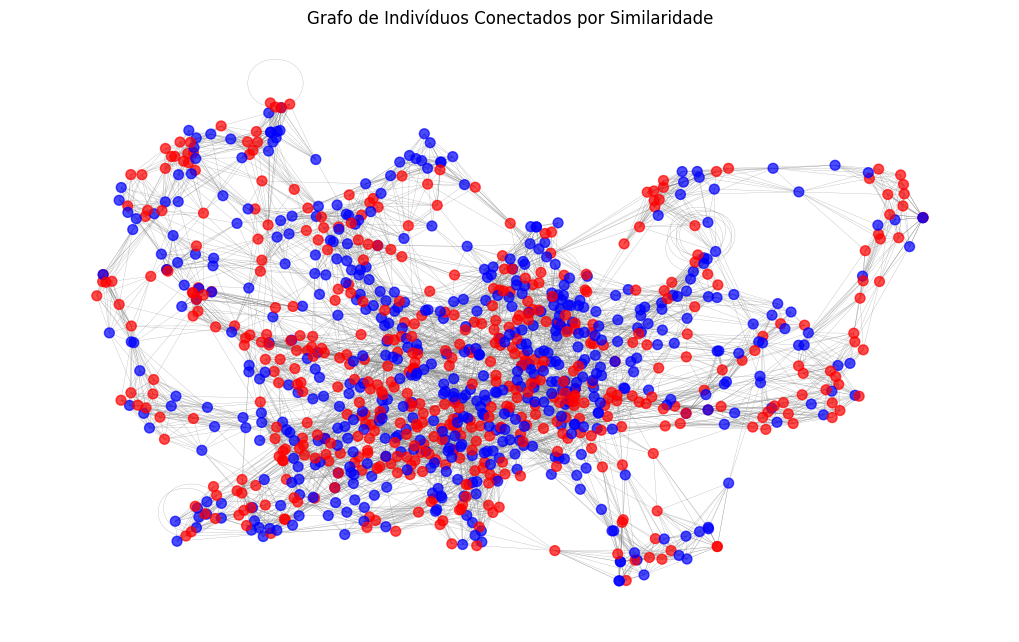

In [207]:
# Criando e visualizando o grafo de treino:

graph_train_pyg = df_to_pyg_with_edges(X_train, y_train, k=10)
plot_graph(graph_train_pyg, db_encoded)

##Grafo de teste:

<ipython-input-203-b576d6a0e059>:19: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



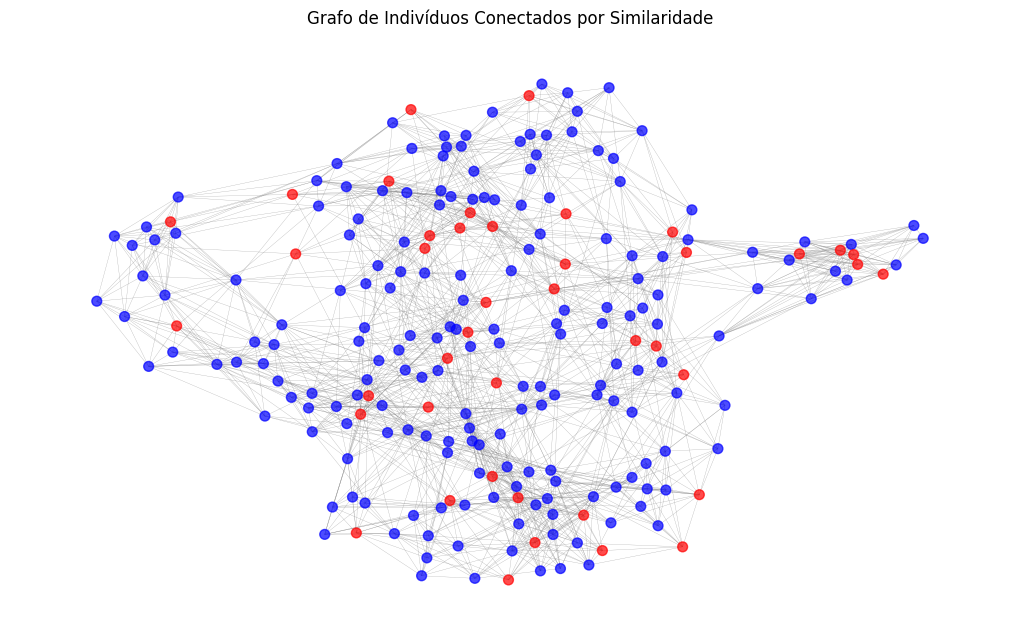

In [208]:
# Criando e visualizando o grafo de teste

graph_test_pyg = df_to_pyg_with_edges(X_test, y_test, k=10)
plot_graph(graph_test_pyg, db_encoded)

##Grafo de validação:

<ipython-input-203-b576d6a0e059>:19: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



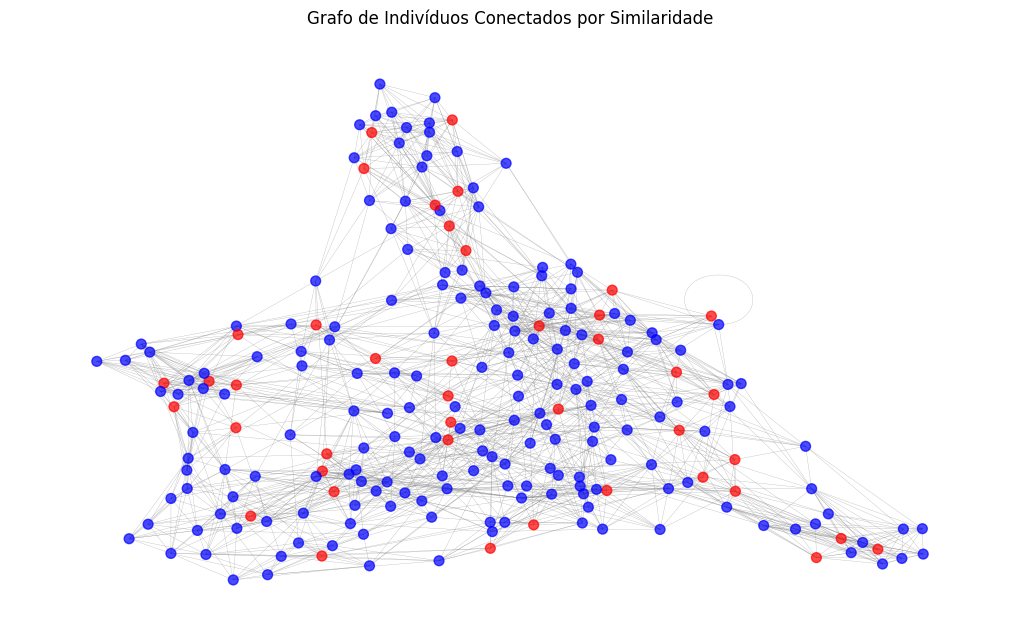

In [209]:
# Criando e visualizando o grafo de validacao:

graph_val_pyg = df_to_pyg_with_edges(X_val, y_val, k=10)
plot_graph(graph_val_pyg, db_encoded)

In [210]:
# Exibindo o graph_train:
graph_train

Data(x=[1071, 24], edge_index=[2, 21420], y=[1071])

In [211]:
# Salvando os grafos:

# salvando o grafo de treinamento:
torch.save(graph_train, 'graph_train.pt')

# salvando o grafo de teste:
torch.save(graph_test, 'graph_test.pt')

# salvando o grafo de validação:
torch.save(graph_val, 'graph_val.pt')

# Iniciando o processo de implantação da rede e o treinamento:

In [212]:
# carregando os grafos:

graph_train = torch.load('/content/graph_train.pt', weights_only=False)
graph_test = torch.load('/content/graph_test.pt', weights_only=False)
graph_val = torch.load('/content/graph_val.pt', weights_only=False)

In [213]:
# verificando o tamanho dos 3 grafos (treinamento, teste e validação):
print(graph_train.x.shape)
print(graph_test.x.shape)
print(graph_val.x.shape)

torch.Size([1071, 24])
torch.Size([230, 24])
torch.Size([230, 24])


In [214]:
# verificando o grafo de treinamento:
print(graph_train.x.shape)
print(graph_train.edge_index.shape)
print(graph_train.y.shape)

torch.Size([1071, 24])
torch.Size([2, 21420])
torch.Size([1071])


In [215]:
# Verificando todos os grafos carregados:
graph_train = Data(x = graph_train.x, edge_index=graph_train.edge_index, y=graph_train.y)
print(graph_train)

graph_test = Data(x = graph_test.x, edge_index=graph_test.edge_index, y=graph_test.y)
print(graph_test)

graph_val = Data(x = graph_val.x, edge_index=graph_val.edge_index, y=graph_val.y)
print(graph_val)

Data(x=[1071, 24], edge_index=[2, 21420], y=[1071])
Data(x=[230, 24], edge_index=[2, 4600], y=[230])
Data(x=[230, 24], edge_index=[2, 4600], y=[230])


In [216]:
# Implementando a rede GNN:
class GNN(torch.nn.Module):
    def __init__(self, activation, neurons, dropout, num_layers=4, aggr='mean'):
        super(GNN, self).__init__()

        self.activation = activation
        self.dropout = nn.Dropout(dropout)
        self.num_layers = num_layers

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        in_channels = 24
        hidden_sizes = [neurons]

        # Gerar a arquitetura com redução progressiva
        for i in range(1, num_layers):
            next_size = max(4, hidden_sizes[-1] // 2)
            hidden_sizes.append(next_size)

        # Criar camadas convolucionais e de batch norm
        for i in range(num_layers):
            out_channels = hidden_sizes[i]
            self.convs.append(SAGEConv(in_channels, out_channels, aggr=aggr))
            self.bns.append(BatchNorm(out_channels))
            in_channels = out_channels  # para a próxima camada

        # Camadas Fully Connected (ajuste conforme o número de classes)
        self.fc1 = nn.Linear(hidden_sizes[-1], hidden_sizes[-1] // 2)
        self.fc2 = nn.Linear(hidden_sizes[-1] // 2, 2)  # classificação binária

        # Reset de parâmetros das camadas GCN
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = self.bns[i](x)
            x = self.activation(x)
            x = self.dropout(x)

        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)


In [217]:
# setando o seed:

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Criando a função 'objective' para otimizar parametros com optuna:

# Definindo a função objetivo do Optuna
def objective(trial):
    set_seed(42 + trial.number) #seed controlada por trial para variar um pouco entre as execucoes

    # Hiperparâmetros sugeridos através do Optuna
    neurons = trial.suggest_int("neurons", 64, 512)  # número de neurônios nas camadas ocultas
    dropout = trial.suggest_float("dropout", 0.05, 0.5, step=0.05)  # taxa de dropout
    lr = trial.suggest_float("lr", 6e-5, 1, log=True)  # taxa de aprendizado
    num_layers = trial.suggest_int("num_layers", 2, 6)

    # Criar o modelo com os parâmetros sugeridos
    model = GNN(activation=torch.nn.LeakyReLU(),
                neurons=neurons,
                dropout=dropout,
                num_layers=num_layers)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    best_val_acc = 0
    patience = 10
    patience_counter = 0

    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        out = model(graph_train)
        loss = criterion(out, graph_train.y)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            out = model(graph_val)
            pred = torch.argmax(out, dim=1)
            acc = accuracy_score(graph_val.y.cpu().numpy(), pred.cpu().numpy())

        trial.report(acc, step=epoch)

        if acc > best_val_acc:
            best_val_acc = acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_val_acc


In [218]:
# Criando um estudo para maximizar a métrica de desempenho (ex: acurácia)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500)  # Defina o número de tentativas

[I 2025-04-29 18:30:09,906] A new study created in memory with name: no-name-5fbe1cb1-8f55-404b-850e-3a1e810aeb08
[I 2025-04-29 18:30:13,050] Trial 0 finished with value: 0.6347826086956522 and parameters: {'neurons': 497, 'dropout': 0.45, 'lr': 0.49067856159384854, 'num_layers': 4}. Best is trial 0 with value: 0.6347826086956522.
[I 2025-04-29 18:30:18,454] Trial 1 finished with value: 0.9 and parameters: {'neurons': 424, 'dropout': 0.15000000000000002, 'lr': 0.05393620952949771, 'num_layers': 3}. Best is trial 1 with value: 0.9.
[I 2025-04-29 18:30:20,235] Trial 2 finished with value: 0.6347826086956522 and parameters: {'neurons': 477, 'dropout': 0.3, 'lr': 0.3321679411187803, 'num_layers': 3}. Best is trial 1 with value: 0.9.
[I 2025-04-29 18:30:26,169] Trial 3 finished with value: 0.9043478260869565 and parameters: {'neurons': 492, 'dropout': 0.05, 'lr': 0.000515386428534671, 'num_layers': 2}. Best is trial 3 with value: 0.9043478260869565.
[I 2025-04-29 18:30:31,189] Trial 4 finis

In [219]:
print("Melhores hiperparâmetros encontrados:")
print(study.best_params)

print("Melhor valor da métrica de avaliação:")
print(study.best_value)

Melhores hiperparâmetros encontrados:
{'neurons': 488, 'dropout': 0.05, 'lr': 0.005670394074905492, 'num_layers': 2}
Melhor valor da métrica de avaliação:
0.9260869565217391


In [220]:
# Plotando o gráfico da convergência (mostra a evolução da métrica ao longo dos trials):
vis.plot_optimization_history(study).show()

# Plotando a importância dos hiperparâmetros:
vis.plot_param_importances(study).show()

#Treinando novamente o modelo, utilizando os melhores parâmetros encontrados para testar os resultados

In [221]:
def treinar_e_avaliar_com_early_stopping(model,
                                         graph_train,
                                         graph_val,
                                         optimizer,
                                         criterion,
                                         n_epochs=300,
                                         patience=20,
                                         scheduler_patience=10,
                                         scheduler_factor=0.5):
    best_val_acc = 0
    best_model_state = None
    patience_counter = 0

    # Scheduler: reduz o LR se não melhorar por X épocas
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', patience=scheduler_patience, factor=scheduler_factor, verbose=True
    )

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(graph_train)
        loss = criterion(out, graph_train.y)
        loss.backward()
        optimizer.step()

        # Avaliação no conjunto de validação
        model.eval()
        with torch.no_grad():
            val_out = model(graph_val)
            val_pred = torch.argmax(val_out, dim=1)
            val_acc = (val_pred == graph_val.y).sum().item() / graph_val.num_nodes

        # Atualizar o scheduler com o valor de validação
        scheduler.step(val_acc)

        # Verificar melhoria
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        print(f"Época {epoch}: Validação acc = {val_acc:.4f} | Melhor até agora = {best_val_acc:.4f}")

        # Early stopping
        if patience_counter >= patience:
            print(f"✅ Early stopping ativado na época {epoch}!\n")
            break

    # Restaurar melhor modelo salvo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Avaliação final no conjunto de validação
    model.eval()
    with torch.no_grad():
        final_out = model(graph_val)
        final_pred = torch.argmax(final_out, dim=1)
        final_acc = (final_pred == graph_val.y).sum().item() / graph_val.num_nodes

    return final_acc


In [222]:
model = GNN(
    activation=torch.nn.ReLU(),
    neurons= study.best_params["neurons"],
    dropout= study.best_params["dropout"],
    aggr= 'mean',
    num_layers = study.best_params["num_layers"]
)

optimizer = torch.optim.Adam(model.parameters(), lr=study.best_params["lr"])
criterion = torch.nn.CrossEntropyLoss()

# Treinar com early stopping + scheduler
final_val_acc = treinar_e_avaliar_com_early_stopping(
    model, graph_train, graph_val, optimizer, criterion,
    n_epochs=300, patience=20, scheduler_patience=10, scheduler_factor=0.5
)

print(f"Acurácia final de validação: {final_val_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.



Época 1: Validação acc = 0.6348 | Melhor até agora = 0.6348
Época 2: Validação acc = 0.7913 | Melhor até agora = 0.7913
Época 3: Validação acc = 0.8348 | Melhor até agora = 0.8348
Época 4: Validação acc = 0.8696 | Melhor até agora = 0.8696
Época 5: Validação acc = 0.8783 | Melhor até agora = 0.8783
Época 6: Validação acc = 0.8739 | Melhor até agora = 0.8783
Época 7: Validação acc = 0.8739 | Melhor até agora = 0.8783
Época 8: Validação acc = 0.8739 | Melhor até agora = 0.8783
Época 9: Validação acc = 0.8739 | Melhor até agora = 0.8783
Época 10: Validação acc = 0.8696 | Melhor até agora = 0.8783
Época 11: Validação acc = 0.8826 | Melhor até agora = 0.8826
Época 12: Validação acc = 0.8870 | Melhor até agora = 0.8870
Época 13: Validação acc = 0.8826 | Melhor até agora = 0.8870
Época 14: Validação acc = 0.8870 | Melhor até agora = 0.8870
Época 15: Validação acc = 0.8826 | Melhor até agora = 0.8870
Época 16: Validação acc = 0.8783 | Melhor até agora = 0.8870
Época 17: Validação acc = 0.8739 


🛠️ Execução 1/10
Época 1: Validação acc = 0.6826 | Melhor até agora = 0.6826
Época 2: Validação acc = 0.7783 | Melhor até agora = 0.7783
Época 3: Validação acc = 0.7652 | Melhor até agora = 0.7783
Época 4: Validação acc = 0.7826 | Melhor até agora = 0.7826
Época 5: Validação acc = 0.8043 | Melhor até agora = 0.8043
Época 6: Validação acc = 0.8087 | Melhor até agora = 0.8087
Época 7: Validação acc = 0.8348 | Melhor até agora = 0.8348
Época 8: Validação acc = 0.8391 | Melhor até agora = 0.8391
Época 9: Validação acc = 0.8391 | Melhor até agora = 0.8391
Época 10: Validação acc = 0.8522 | Melhor até agora = 0.8522
Época 11: Validação acc = 0.8522 | Melhor até agora = 0.8522
Época 12: Validação acc = 0.8652 | Melhor até agora = 0.8652
Época 13: Validação acc = 0.8609 | Melhor até agora = 0.8652
Época 14: Validação acc = 0.8609 | Melhor até agora = 0.8652
Época 15: Validação acc = 0.8565 | Melhor até agora = 0.8652
Época 16: Validação acc = 0.8565 | Melhor até agora = 0.8652
Época 17: Valid

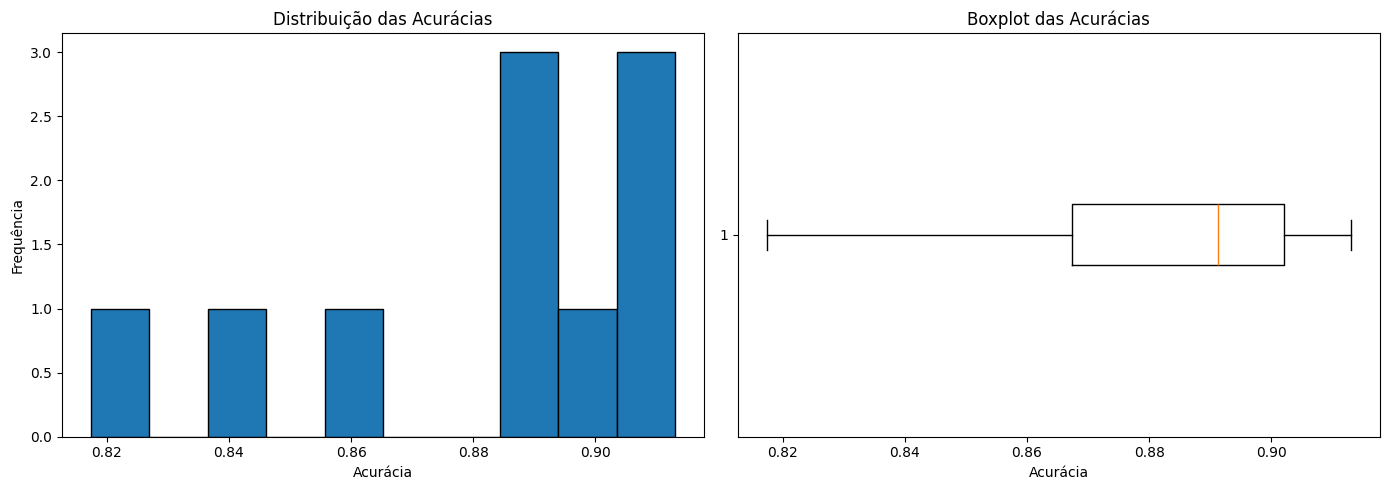

In [223]:
# Função para fixar seed
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Função para treinar e avaliar com early stopping (já criada antes)

# Função principal para testar múltiplas execuções + visualizar
def testar_muitos_treinamentos(n_execucoes=10):
    accs = []

    for i in range(n_execucoes):
        print(f"\n🛠️ Execução {i+1}/{n_execucoes}")

        set_seed(42 + i)

        model = GNN(
            activation=torch.nn.ReLU(),
            neurons=64,
            dropout=0.5,
            aggr='mean',  # ou 'max', 'lstm'
            num_layers=3
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        criterion = torch.nn.CrossEntropyLoss()

        acc_val = treinar_e_avaliar_com_early_stopping(
            model, graph_train, graph_val, optimizer, criterion,
            n_epochs=300, patience=20, scheduler_patience=10, scheduler_factor=0.5
        )

        accs.append(acc_val)

    accs = np.array(accs)

    # Resultados estatísticos
    print("\n📊 Resultado final:")
    print(f"Acurácia média de validação: {accs.mean():.4f}")
    print(f"Desvio padrão da acurácia: {accs.std():.4f}")
    print(f"Melhor acurácia atingida: {accs.max():.4f}")
    print(f"Pior acurácia atingida: {accs.min():.4f}")

    # Visualizações 📈
    plt.figure(figsize=(14, 5))

    # Histograma
    plt.subplot(1, 2, 1)
    plt.hist(accs, bins=10, edgecolor='black')
    plt.title('Distribuição das Acurácias')
    plt.xlabel('Acurácia')
    plt.ylabel('Frequência')

    # Boxplot
    plt.subplot(1, 2, 2)
    plt.boxplot(accs, vert=False)
    plt.title('Boxplot das Acurácias')
    plt.xlabel('Acurácia')

    plt.tight_layout()
    plt.show()

# Para executar:
testar_muitos_treinamentos(n_execucoes=10)


In [225]:
# Avaliação no grafo final de teste:
model.eval()

with torch.no_grad():
    out = model(graph_test)
    pred = torch.argmax(out, dim=1)

    true_labels = graph_test.y
    if true_labels.dim() > 1:
        true_labels = torch.argmax(true_labels, dim=1)

    accuracy = accuracy_score(true_labels.cpu().numpy(), pred.cpu().numpy())
    print(f"Acurácia no grafo de teste final: {accuracy:.4f}")


Acurácia no grafo de teste final: 0.8609


In [226]:
# Colocando o modelo em modo de avaliação: desativando dropout e BatchNorm em treino:
model.eval()
with torch.no_grad():
    out = model(graph_test)
    y_pred = torch.argmax(out, dim=1).cpu().numpy() #recebendo as previsoes
    y_true = graph_test.y.cpu().numpy() #recebendo as previsoes
    if y_true.ndim > 1:
        y_true = np.argmax(y_true, axis=1)

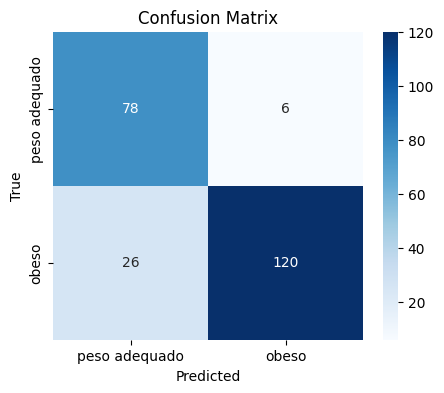

In [227]:
# Plotando uma matriz de confusão com os resultados reais X previsões:
classes = ['peso adequado', 'obeso'] # definindo as classes de interesse
cm = confusion_matrix(y_true, y_pred,labels=[0, 1])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
#plt.savefig('confusion_matrix.png') #salvando em PDF a imagem da matriz
plt.show()

In [228]:
# Calculando e exibindo um relatório detalhado de desempenho do modelo:
print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.750     0.929     0.830        84
           1      0.952     0.822     0.882       146

    accuracy                          0.861       230
   macro avg      0.851     0.875     0.856       230
weighted avg      0.878     0.861     0.863       230



In [ ]:
# só para garantir que estejam alinhados pelo índice:
db = db.reset_index(drop=True)
db_encoded = db_encoded.reset_index(drop=True)

# “puxe” a coluna is_test para o raw
db['is_test'] = db_encoded['is_test']

In [229]:
db.head()

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Status
0,0,21,1,0,2.0,3.0,Sometimes,0,2.0,0,0.0,1.0,no,Public_Transportation,peso adequado
1,0,21,1,0,3.0,3.0,Sometimes,1,3.0,1,3.0,0.0,Sometimes,Public_Transportation,peso adequado
2,1,23,1,0,2.0,3.0,Sometimes,0,2.0,0,2.0,1.0,Frequently,Public_Transportation,peso adequado
3,1,29,0,1,2.0,3.0,Sometimes,0,2.0,0,0.0,0.0,Sometimes,Automobile,peso adequado
4,0,23,1,1,3.0,3.0,Sometimes,0,2.0,0,1.0,0.0,Sometimes,Motorbike,peso adequado


In [230]:
# (re)garanta que db_encoded está alinhado com db
db = db.reset_index(drop=True)
db_encoded = db_encoded.reset_index(drop=True)
db['is_test'] = db_encoded['is_test']

# atribua direto pelos índices de X_test
db['Predict'] = np.nan
db.loc[X_test.index, 'Predict'] = y_pred

# (se ainda quiser exibir legível)
db['Predict'] = db['Predict'].map({0: 'peso adequado', 1: 'obeso'})

# Verifique:
print(db['Predict'].notna().sum())   # deve dar 230


230


In [231]:
db.head()

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Status,is_test,Predict
0,0,21,1,0,2.0,3.0,Sometimes,0,2.0,0,0.0,1.0,no,Public_Transportation,peso adequado,False,NaN
1,0,21,1,0,3.0,3.0,Sometimes,1,3.0,1,3.0,0.0,Sometimes,Public_Transportation,peso adequado,True,peso adequado
2,1,23,1,0,2.0,3.0,Sometimes,0,2.0,0,2.0,1.0,Frequently,Public_Transportation,peso adequado,False,NaN
3,1,29,0,1,2.0,3.0,Sometimes,0,2.0,0,0.0,0.0,Sometimes,Automobile,peso adequado,False,NaN
4,0,23,1,1,3.0,3.0,Sometimes,0,2.0,0,1.0,0.0,Sometimes,Motorbike,peso adequado,False,NaN


In [232]:
# Reorganizando as duas ultimas colunas:

# 1. Remove temporariamente as duas colunas
pred = db.pop('Predict')
is_t = db.pop('is_test')

# 2. Insere 'Predict' logo após a coluna 'Status'
db.insert(db.columns.get_loc('Status') + 1, 'Predict', pred)

# 3. Readiciona 'is_test' no final
db['is_test'] = is_t

# Substituindo NaN por - :
db = db.fillna('-')

<ipython-input-232-4d19eb0b4582>:14: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [233]:
db.head()

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Status,Predict,is_test
0,0,21,1,0,2.0,3.0,Sometimes,0,2.0,0,0.0,1.0,no,Public_Transportation,peso adequado,-,False
1,0,21,1,0,3.0,3.0,Sometimes,1,3.0,1,3.0,0.0,Sometimes,Public_Transportation,peso adequado,peso adequado,True
2,1,23,1,0,2.0,3.0,Sometimes,0,2.0,0,2.0,1.0,Frequently,Public_Transportation,peso adequado,-,False
3,1,29,0,1,2.0,3.0,Sometimes,0,2.0,0,0.0,0.0,Sometimes,Automobile,peso adequado,-,False
4,0,23,1,1,3.0,3.0,Sometimes,0,2.0,0,1.0,0.0,Sometimes,Motorbike,peso adequado,-,False


In [234]:
# db.to_excel('database_obesity_with_flag.xlsx', index=False, sheet_name='Dados')